In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import auc
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Allow for plotting in the notebook.
%matplotlib inline

# Customer Churn Analysis: Logistic Regression

Phase one involves loading the data, examining it for any anomoloies and then prepping it to be loaded into the model.

In [3]:
# Read in data
df = pd.read_csv('data/reg_data.csv')

# Print some info.
df.info()

# Count the number of nulls.
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 22 columns):
Unnamed: 0          7043 non-null int64
customerid          7043 non-null object
gender              7043 non-null object
seniorcitizen       7043 non-null int64
partner             7043 non-null object
dependents          7043 non-null object
tenure              7043 non-null int64
phoneservice        7043 non-null object
multiplelines       7043 non-null object
internetservice     7043 non-null object
onlinesecurity      7043 non-null object
onlinebackup        7043 non-null object
deviceprotection    7043 non-null object
techsupport         7043 non-null object
streamingtv         7043 non-null object
streamingmovies     7043 non-null object
contract            7043 non-null object
paperlessbilling    7043 non-null object
paymentmethod       7043 non-null object
monthlycharges      7043 non-null float64
totalcharges        7043 non-null float64
churn               7043 non-null

Unnamed: 0          0
customerid          0
gender              0
seniorcitizen       0
partner             0
dependents          0
tenure              0
phoneservice        0
multiplelines       0
internetservice     0
onlinesecurity      0
onlinebackup        0
deviceprotection    0
techsupport         0
streamingtv         0
streamingmovies     0
contract            0
paperlessbilling    0
paymentmethod       0
monthlycharges      0
totalcharges        0
churn               0
dtype: int64

# Data Cleaning:

In [4]:
# we don't need the unamed column and customer ID column, so let's remove them. Keep all rows ":," but skip the first 2 column "2:"
df_cleaned = df.iloc[:, 2:]

# Print out the new dataframe.
df_cleaned.head()

,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
# The model requires binary data, so we need to convert
# our `Yes` to `1` and `No` to `0`.
df_cleaned.churn.replace(
    {"Yes": 1, "No": 0},
    inplace = True
)

# Utilize pandas dummy variable function to create
# dummy variable series for categorical data.
dummy_df = pd.get_dummies(df_cleaned)

# Save it to a CSV File, so we can load it again easily.
dummy_df.to_csv('data/final_df.csv')

# Print the info again.
dummy_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 46 columns):
seniorcitizen                              7043 non-null int64
tenure                                     7043 non-null int64
monthlycharges                             7043 non-null float64
totalcharges                               7043 non-null float64
churn                                      7043 non-null int64
gender_Female                              7043 non-null uint8
gender_Male                                7043 non-null uint8
partner_No                                 7043 non-null uint8
partner_Yes                                7043 non-null uint8
dependents_No                              7043 non-null uint8
dependents_Yes                             7043 non-null uint8
phoneservice_No                            7043 non-null uint8
phoneservice_Yes                           7043 non-null uint8
multiplelines_No                           7043 non-null uint8
multipl

# Graphing: Correlations Bar Chart

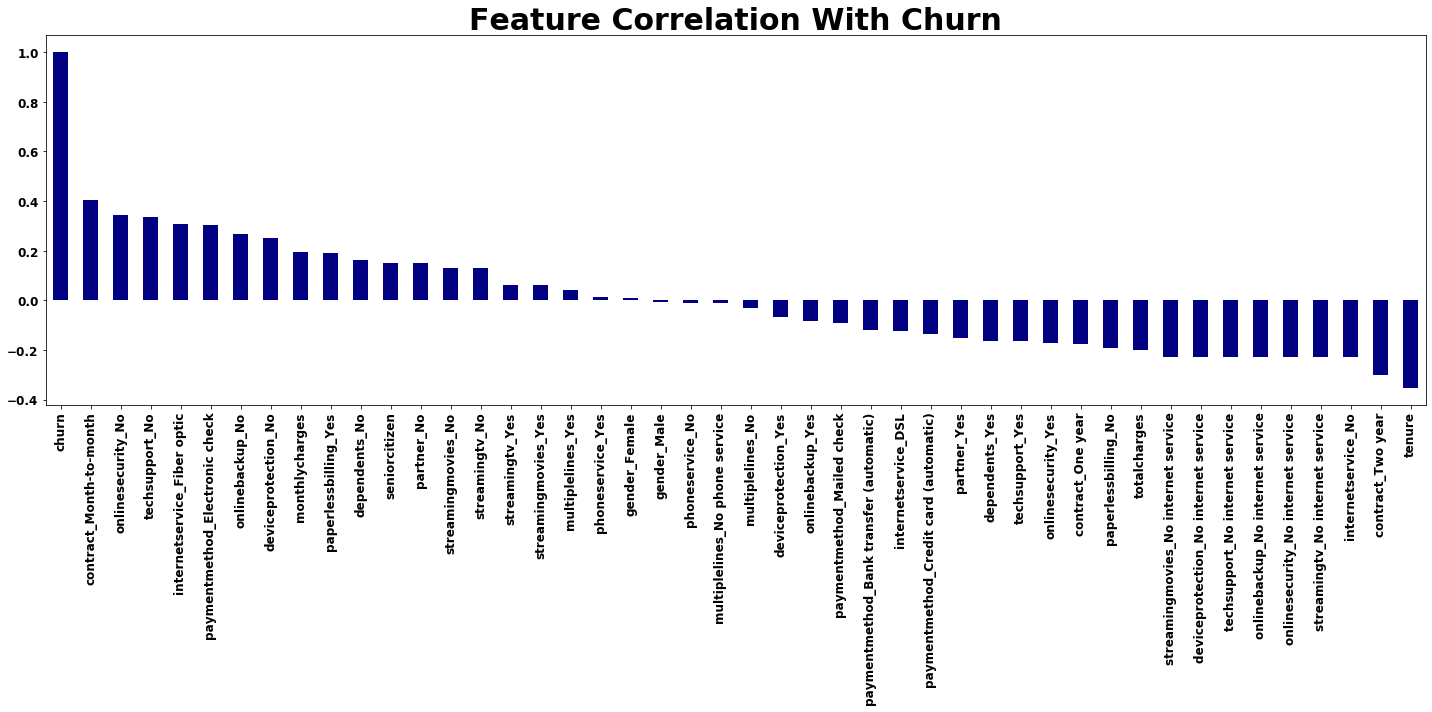

In [8]:
# Step 1: Calculate the Correlation between each variable and the Churn variable.
corr_df = dummy_df.corr()['churn']

# Step 2: Sort the values.
corr_df = corr_df.sort_values(ascending=False)

# Step 3: Create a Bar Chart.
corr_df.plot(
    'bar',
    figsize=(20, 10),
    color='Navy'
)

# Add the Ticks.
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')

# Add the Title.
plt.title(
    'Feature Correlation With Churn',
    fontsize=30,
    fontweight='bold'
)

# Make it a Tight Layout.
plt.tight_layout()

# Graphing: Correlations Heatmap

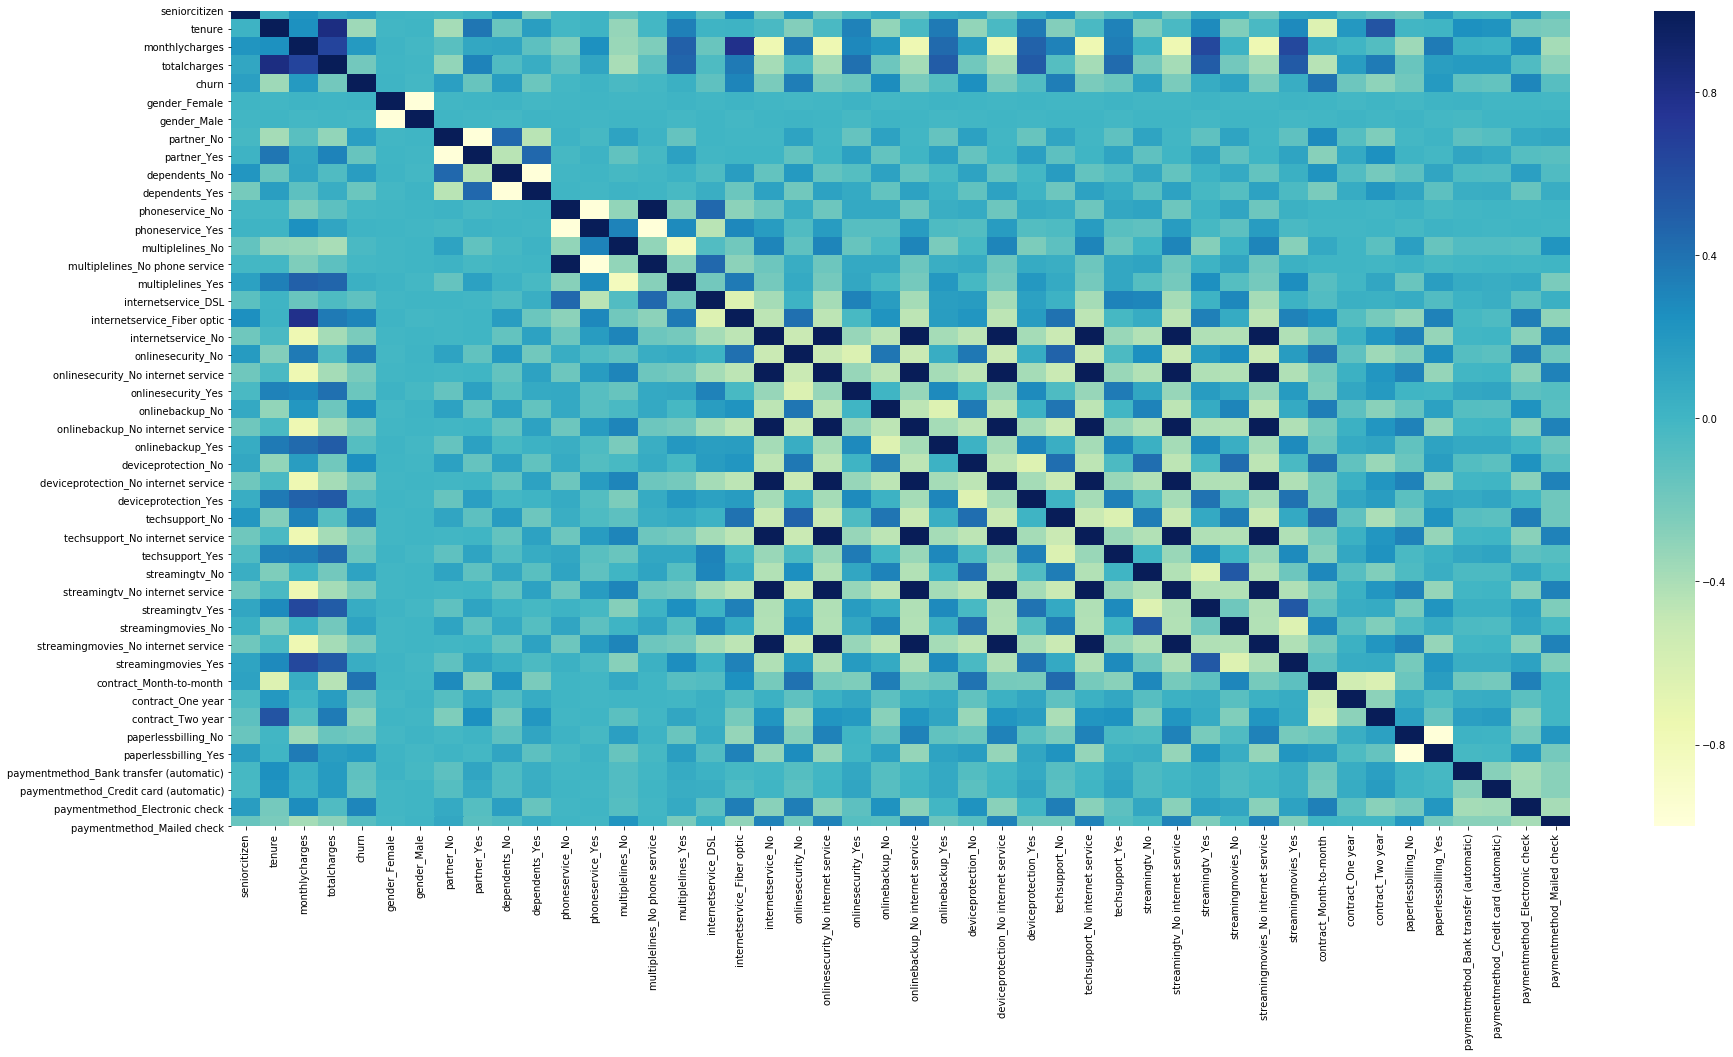

In [9]:
# This time we will use a heatmap to visualize our correlation. This time set the figure size.
plt.figure(figsize = (30, 15))

# Use the Correlations again, and pass them through to the heatmap.
heatmap = sns.heatmap(
    dummy_df.corr(),
    cmap='YlGnBu'
)

First thing to note is the darker the blue, the higher the correlation. While it's kind of hard to see at first glance, we see that monthly contract, and a lack of online security or techsupport have the strongest *positive* correlation with churn. On the opposite end we see that having a 2-Year Contracts and not having internet service are the most negatively correlated with churn.

# Bulding the Model: Pre-Processing Data for Logistic Regression

In [10]:
# Establish our target feature, churn, as our y feature
y = dummy_df.churn.values

# Drop our target feature from our features dataframe
X = dummy_df.drop('churn', axis = 1)

# Save dataframe column titles to list for reassigning after min-max scale.
cols = X.columns

# Instantiate min-max scaling object.
mm = MinMaxScaler()

# Fit and transform our feature dataframe.
X = pd.DataFrame(mm.fit_transform(X))

# Reassign column names so new dataframe has corresponding names.
X.columns = cols

# Bulding the Model: Splitting the Dataset

In [11]:
# Split the dataset so we have a training and testing set, in this case set aside 30% of the data for testing.
# Additionally add a random state so we can reproduce the results.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.30, random_state=33)

# Building the Model: Initializing the Logistic Regression Object

In [12]:
# Instantiate a Logistic Regression model.
#   1) Without an intercept.
#   2) C is set to an arbitrarily large number. 
#   3) Use `liblinear` solver method.
log_reg = LogisticRegression(
    fit_intercept=False,
    C=1e12,
    solver='liblinear'
)

# Fit the model to our X and y training sets.
log_reg.fit(X_train, y_train)

LogisticRegression(C=1000000000000.0, class_weight=None, dual=False,
                   fit_intercept=False, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [13]:
# Generate model prediction data for train and test sets
y_hat_train = log_reg.predict(X_train)
y_hat_test = log_reg.predict(X_test)

# Model Evaluation:

## Question 1: How many times was the classifier correct on the training set?

In [14]:
# Find residual differences between train data and predicted train data.
residuals = np.abs(y_train - y_hat_train)

# Print value counts of our predicted values.
print("Non-Normalized Residuals Count")
print(pd.Series(residuals).value_counts())
print('-'*30)
print('')

# Sometimes we need to see it as percentages to help grasp the data.
print("Normalized Residuals Count")
print(pd.Series(residuals).value_counts(normalize=True))
print('-'*30)
print('')

Non-Normalized Residuals Count
0    3995
1     935
dtype: int64
------------------------------

Normalized Residuals Count
0    0.810345
1    0.189655
dtype: float64
------------------------------



## Question 2: How many times was the classifier correct on the test set?

In [15]:
# Repeat the same steps, but this time we will use the Test dataset and NOT the training set.
residuals = np.abs(y_test - y_hat_test)

# Print value counts of our predicted values.
print("Non-Normalized Residuals Count")
print(pd.Series(residuals).value_counts())
print('-'*30)
print('')

# Sometimes we need to see it as percentages to help grasp the data.
print("Normalized Residuals Count")
print(pd.Series(residuals).value_counts(normalize=True))
print('-'*30)
print('')

Non-Normalized Residuals Count
0    1684
1     429
dtype: int64
------------------------------

Normalized Residuals Count
0    0.796971
1    0.203029
dtype: float64
------------------------------



## Evaluation: Confusion Matrix

In [16]:
# SkLearn makes this easy, we can just call the "confusion_matrix" function.
confusion_mtrx = confusion_matrix(y_test, y_hat_test)

print("Confusion Matrix:")
print(confusion_mtrx)

Confusion Matrix:
[[1382  165]
 [ 264  302]]


In [24]:
# In this portion, we will print some common model metrics: Percision, Recall, Accuracy, F1.
data = {
    'Training - Precision': round(precision_score(y_train, y_hat_train), 2),
    'Training - Accuracy': round(accuracy_score(y_train, y_hat_train), 2),
    'Training - Recall': round(recall_score(y_train, y_hat_train), 2),
    'Training - F1': round(f1_score(y_train, y_hat_train), 2),
    'Testing - Precision': round(precision_score(y_test, y_hat_test), 2),
    'Testing - Accuracy': round(accuracy_score(y_test, y_hat_test), 2),
    'Testing - Recall': round(recall_score(y_test, y_hat_test), 2),
    'Testing - F1': round(f1_score(y_test, y_hat_test), 2),
}

# Add it to a Dataframe.
metrics_df = pd.DataFrame(data=data, index=[0]).T

# Display it.
metrics_df

,0
Training - Precision,0.67
Training - Accuracy,0.81
Training - Recall,0.56
Training - F1,0.61
Testing - Precision,0.65
Testing - Accuracy,0.80
Testing - Recall,0.53
Testing - F1,0.58


# Model Evaluation: Multiple Runs
Sometimes we can just run the model multiple times, while changing different values and see what the result is. In this situation, we will run the model a few dozen times and see how how the metrics change.

In [41]:
def generate_model_results(x, y) -> tuple:

    # Generate the a dictionary for the training results.
    training_results = {
        'percision': [],
        'recall': [],
        'accuracy': [],
        'f1': []
    }

    # Generate the a dictionary for the testing results.
    testing_results = {
        'percision': [],
        'recall': [],
        'accuracy': [],
        'f1': []
    }

    for iteration in range(10, 95):

        # Define the Train/Test Split.
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=iteration/100.0, random_state=33)

        # Define the Model.
        log_reg = LogisticRegression(
            fit_intercept=False,
            C=1e25,
            solver='liblinear'
        )

        # Fit the data.
        model_log = log_reg.fit(X_train, y_train)

        # Grab some predictions.
        y_hat_test = log_reg.predict(X_test)
        y_hat_train = log_reg.predict(X_train)

        # Append the results.
        training_results['percision'].append(precision_score(y_train, y_hat_train))
        training_results['recall'].append(recall_score(y_train, y_hat_train))
        training_results['accuracy'].append(accuracy_score(y_train, y_hat_train))
        training_results['f1'].append(f1_score(y_train, y_hat_train))

        testing_results['percision'].append(precision_score(y_test, y_hat_test))
        testing_results['recall'].append(recall_score(y_test, y_hat_test))
        testing_results['accuracy'].append(accuracy_score(y_test, y_hat_test))
        testing_results['f1'].append(f1_score(y_test, y_hat_test))
    
    return (training_results, testing_results)

def graph_results(training_results: dict, testing_results: dict):
    
    range_size = list(range(10, 95))

    # Use subplots to create a scatter plot of each of the 4 metrics. 
    plt.figure(figsize=(20, 10))


    # DEFINE THE PERCISION CHART.
    plt.subplot(221)
    plt.title('Score: Precision', fontweight='bold', fontsize=25)
    plt.xlabel('Model Test Size - %', fontsize=15)

    # Use the data in the dictionaries.
    plt.scatter(range_size, training_results['percision'], label='Training Precision')
    plt.scatter(range_size, testing_results['percision'], label='Testing Precision')
    
    # Add a legend.
    plt.legend(loc='best')


    # DEFINE THE RECALL CHART.
    plt.subplot(222)
    plt.title('Score: Recall', fontweight='bold', fontsize=25)
    plt.xlabel('Model Test Size - %', fontsize=15)

    # Use the data in the dictionaries.
    plt.scatter(range_size, training_results['recall'], label='Training Recall')
    plt.scatter(range_size, testing_results['recall'], label='Testing Recall')
    
    # Add a legend.
    plt.legend(loc='best')


    # DEFINE THE ACCURACY CHART.
    plt.subplot(223)
    plt.title('Score: Accuracy', fontweight='bold', fontsize=25)
    plt.xlabel('Model Test Size - %', fontsize=15)

    # Use the data in the dictionaries.
    plt.scatter(range_size, training_results['accuracy'], label='Training Accuracy')
    plt.scatter(range_size, testing_results['accuracy'], label='Testing Accuracy')
    
    # Add a legend.
    plt.legend(loc='best')


    # DEFINE THE F1 CHART.
    plt.subplot(224)
    plt.title('Score: F1', fontweight='bold', fontsize=25)
    plt.xlabel('Model Test Size - %', fontsize=15)

    # Use the data in the dictionaries.
    plt.scatter(range_size, training_results['f1'], label='Training F1')
    plt.scatter(range_size, testing_results['f1'], label='Testing F1')
    
    # Add a legend.
    plt.legend(loc='best')


    # Finally, plot it.
    plt.tight_layout()


In [35]:
results=generate_model_results(x=X, y=y)

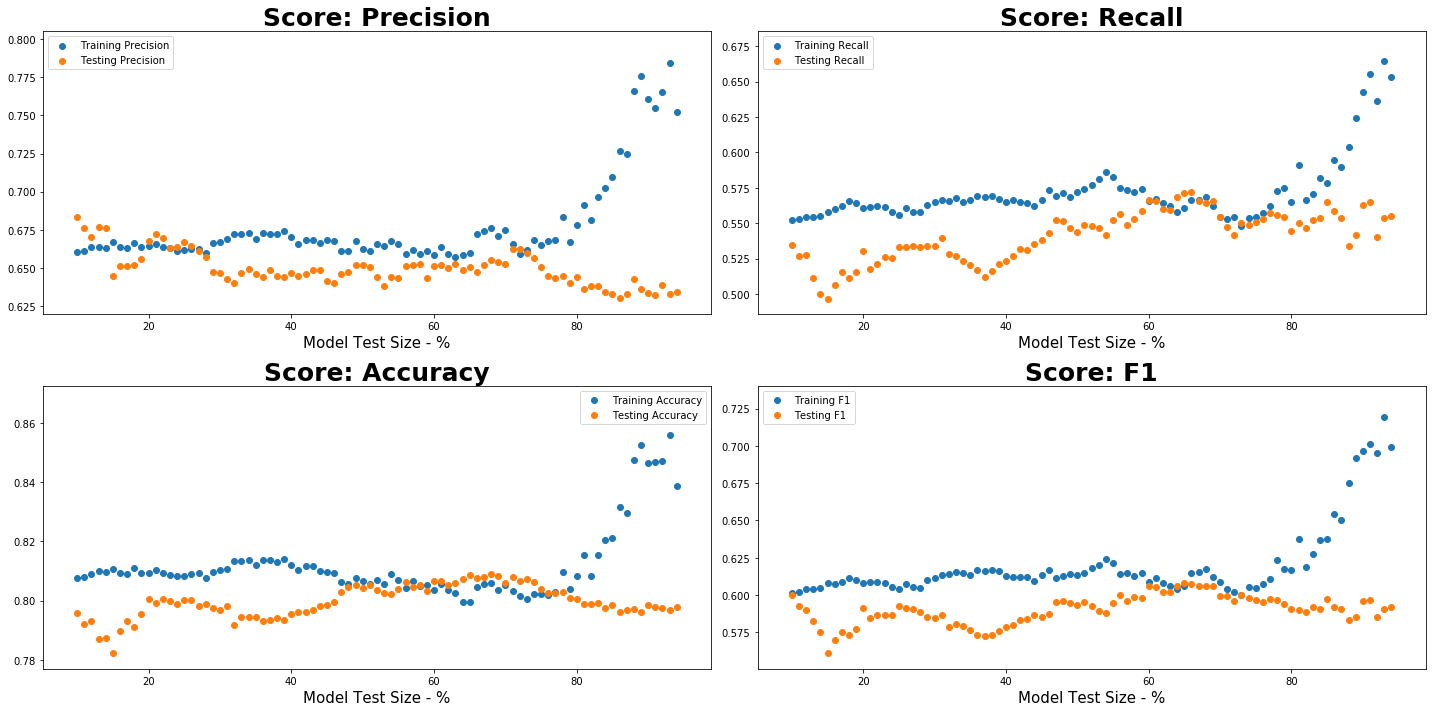

In [42]:
graph_results(training_results=results[0], testing_results=results[1])

# Model Evaluation: ROC Curves

We will now calculate probability scores for our y-train and y-test datasets. We use the false positive and true positive rates to plot a ROC Curve (receiver operating characteristic curve) for both train and test sets.

In [66]:

fpr, tpr, thresholds = roc_curve(y_test, log_reg.predict_proba(X_test)[:,1])

fpr, tpr, thresholds = roc_curve(y_train, log_reg.predict_proba(X_train)[:,1])


In [78]:
def generate_roc_curves(model, X_train, y_train, X_test, y_test):

    # Set the Font.
    font_dict = {
        'fontsize': 20,
        'fontweight': 'bold'
    }

    # Set the ticks.
    ticks=[i/20.0 for i in range(21)]

    # Generate the Training ROC Curve Values.
    train_fpr, train_tpr, train_thresholds = roc_curve(y_test, log_reg.predict_proba(X_test)[:,1])

    # Generate the Testing ROC Curve Values.
    test_fpr, test_tpr, test_thresholds = roc_curve(y_train, log_reg.predict_proba(X_train)[:,1])
    
    # Define the data.
    data = {
        'Training: AUC': auc(train_fpr, train_tpr),
        'Testing: AUC': auc(test_fpr, test_tpr)
    }

    auc_df = pd.DataFrame(data=data, index=[0]).T
    display(auc_df)
    
    # Define the plot.
    plt.figure(figsize = (20, 8))
    lw = 2
    
    # Use Train False/True Positive ratios to plot receiver operating characteristic curve for training set
    plt.subplot(121)
    plt.plot(
        train_fpr,
        train_tpr,
        color='red',
        lw=lw,
        label='ROC Curve'
    )

    # Plot positive line w/ slope = 1 for ROC-curve reference
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])

    # Set the ticks.
    plt.yticks(ticks)
    plt.xticks(ticks)

    # Define the Labels.
    plt.title('ROC Curve: Training Set', fontdict=font_dict)
    plt.xlabel('False Positive Rate', fontdict=font_dict)
    plt.ylabel('True Positive Rate', fontdict=font_dict)
    plt.legend(loc='lower right')

    # Use Test False/True positive ratios to plot receiver operating characteristic curve for test set
    plt.subplot(122)
    plt.plot(
        test_fpr,
        test_tpr,
        color='red',
        lw=lw,
        label='ROC curve'
    )
    
    # Plot positive line w/ slope = 1 for ROC-curve reference
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])

    # Set the ticks.
    plt.yticks(ticks)
    plt.xticks(ticks)

    # Define the Labels.
    plt.title('ROC Curve: Testing Set', fontdict=font_dict)
    plt.xlabel('False Positive Rate', fontdict=font_dict)
    plt.ylabel('True Positive Rate', fontdict=font_dict)
    plt.legend(loc='lower right')

    # Plot it.
    plt.tight_layout()

,0
Training: AUC,0.833859
Testing: AUC,0.854317


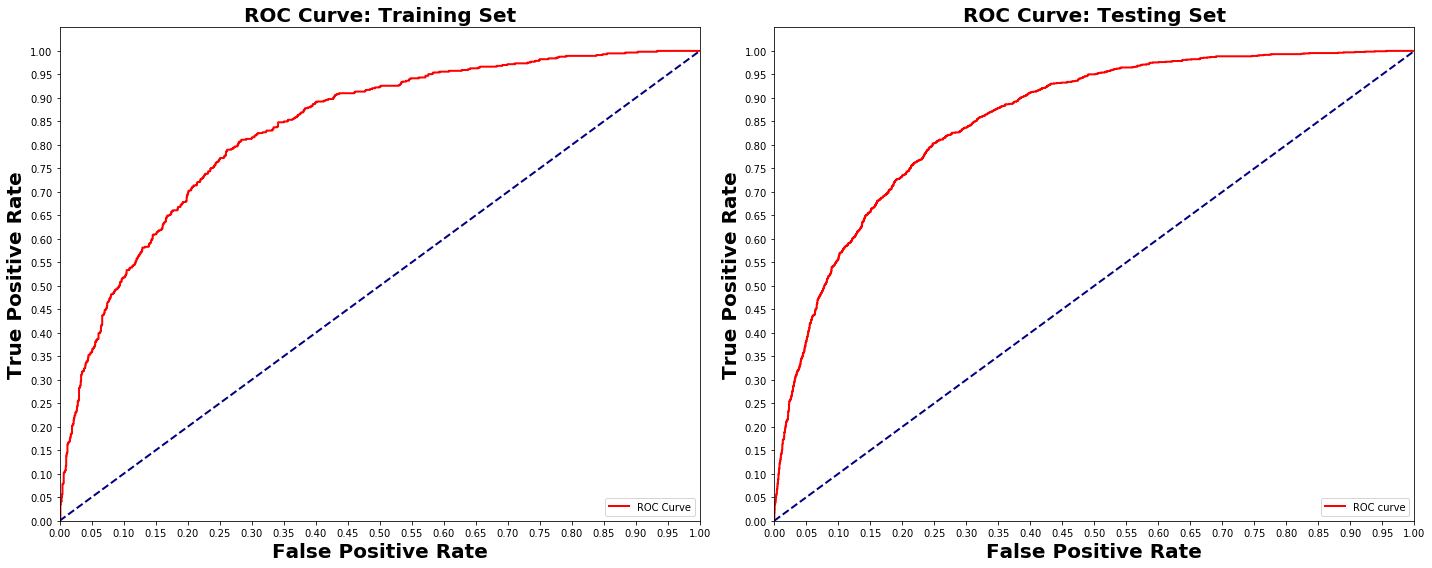

In [79]:
generate_roc_curves(log_reg, X_train, y_train, X_test, y_test)